In [1]:

import multiprocessing
print(multiprocessing.cpu_count())

import psutil
print(f"Available memory before training: {psutil.virtual_memory().available / 1e9:.2f} GB")

12
Available memory before training: 9.20 GB


In [2]:

import numpy as np
import pandas as pd
pd.set_option('display.max_info_columns', 200) #caps at 200, use None to show all
pd.set_option('display.max_rows', 200)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import pickle

In [3]:

token = 'p25'
study = pd.read_pickle("p004_diabetes_MLprep.pkl")

for col in study.select_dtypes(include='int64'):
    study[col] = study[col].astype('int32')
    
print(study.shape)

(78743, 176)


In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score as accuracy_score_sklearn
import xgboost 
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score

In [5]:

X = study.drop(['readmitted_ind'], axis=1)
y = study['readmitted_ind']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# leave these features in the data, but do not use them for modeling
exclude_features = ['patient_nbr', 'encounter_id', 'diagnosis_tuple', 'readmitted', 'dummy'] 
numeric_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'int32']
object_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])

In [6]:

def evaluate_and_save_pipeline(pipeline, namestring, token, 
                               X_train, X_test, 
                               y_train, y_test):
    """
    Evaluates a trained pipeline and saves metrics to a pickle file.
    """

    # Properly check for missing inputs
    if any(v is None for v in [X_train, X_test, y_train, y_test]):
        raise ValueError("X_train, X_test, y_train, or y_test must not be None.")

    # Ensure data is in expected format (convert to numpy if necessary)
    y_train = y_train.values if hasattr(y_train, "values") else y_train
    y_test = y_test.values if hasattr(y_test, "values") else y_test

    # Make predictions
    y_test_pred  = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)
    
    # Determine if model supports predict_proba or decision_function
    if hasattr(pipeline, "predict_proba"):
        print('pipeline.predict_proba(X_test)[:, 1] used for y_test_pred_pct')
        y_test_pred_pct = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        print('pipeline.decision_function(X_test) used for y_test_pred_pct')
        y_test_pred_pct = pipeline.decision_function(X_test)
    else:
        raise AttributeError("🚨 This pipeline has neither predict_proba() nor decision_function(). Cannot generate continuous scores for ROC/AUC.")
    

    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = pipeline.score(X_test, y_test)

    # Confusion matrix & sensitivity/specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_pct)
    roc_auc = auc(fpr, tpr)

    accuracy= (tp+tn)/ (tp+tn+fp+fn)
    accuracy_score= accuracy_score_sklearn(y_test, y_test_pred)

    # Save metrics
    fits_pickle = {
        'model_version': f"{token}_{namestring}",
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'y_test': y_test,
        
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
        'y_test_pred_pct': y_test_pred_pct,
        'display_labels': pipeline.classes_ ,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'accuracy': accuracy,
        'accuracy_score': accuracy_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc
    }

    with open(f"fits_pickle_{token}_{namestring}.pkl", "wb") as file:
        pickle.dump(fits_pickle, file)
    print(f"Fits data saved as fits_pickle_{token}_{namestring}.pkl")

    # Print summary
    print(f"Metrics saved to {filename}")
    print('MSE (Train):',  round(mse_train,4))
    print('MSE (Test):',   round(mse_test, 4))
    print('R-sq (Train):', round(r2_train, 4))
    print('R-sq (Test):',  round(r2_test,  4))
    print('Accuracy:',     round(accuracy,4))
    print('accuracy_score:',     round(accuracy_score,4))
    print('Sensitivity:',  round(sensitivity, 4))
    print('Specificity:',  round(specificity,  4))

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Test Data Confusion Matrix for {namestring} fit")
    plt.show()

    return fits_pickle

In [7]:

# Best params from p24_XGB
best_params={'subsample': 1.0
 , 'reg_lambda': 10.0
 , 'reg_alpha': 0.004641588833612777
 , 'n_estimators': 500
 , 'min_child_weight': 3
 , 'max_depth': 5, 'learning_rate': 0.1
 , 'gamma': 0.5
 , 'colsample_bytree': 0.75}


In [8]:

%%time
# Step 1: extract the base model (without pipeline)
base_model = xgboost.XGBClassifier(**best_params, eval_metric='logloss', random_state=43)

# Step 2: calibrate the base model (not the pipeline)
calibrated_model = CalibratedClassifierCV(base_model, cv=5, method='sigmoid')

# Step 3: build a new pipeline
calibratedXGB = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', calibrated_model)
])

# Fit on full training data
calibratedXGB.fit(X_train, y_train)

filename=f"{token}_calibratedXGB.pkl"
with open(filename, "wb") as file:
    pickle.dump(calibratedXGB, file)
print(f"Model saved as {filename}")

Model saved as p25_calibratedXGB.pkl
CPU times: total: 1min 57s
Wall time: 17.2 s


pipeline.predict_proba(X_test)[:, 1] used for y_test_pred_pct
Fits data saved as fits_pickle_p25_calibratedXGB.pkl
Metrics saved to p25_calibratedXGB.pkl
MSE (Train): 0.0254
MSE (Test): 0.034
R-sq (Train): 0.9746
R-sq (Test): 0.966
Accuracy: 0.966
accuracy_score: 0.966
Sensitivity: 0.9681
Specificity: 0.9643


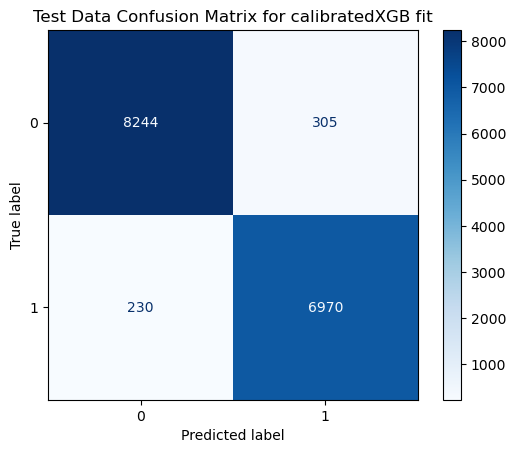

{'model_version': 'p25_calibratedXGB',
 'mse_train': 0.025430993427945518,
 'mse_test': 0.033970410819734585,
 'r2_train': 0.9745690065720545,
 'r2_test': 0.9660295891802654,
 'y_test': array([1, 1, 1, ..., 1, 0, 1]),
 'y_test_pred': array([1, 1, 1, ..., 1, 0, 1]),
 'y_train_pred': array([0, 0, 0, ..., 1, 0, 0]),
 'y_test_pred_pct': array([0.98553585, 0.8153762 , 0.98554571, ..., 0.98557656, 0.00761577,
        0.98556596]),
 'display_labels': array([0, 1]),
 'tn': 8244,
 'fp': 305,
 'fn': 230,
 'tp': 6970,
 'accuracy': 0.9660295891802654,
 'accuracy_score': 0.9660295891802654,
 'sensitivity': 0.9680555555555556,
 'specificity': 0.9643233126681483,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.98233712, 0.98257106,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.38888889e-04, 4.16666667e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'thresholds': array([       inf, 0.98558222, 0.98558195, ..., 0.00761415, 0.00761415,
        0.00761193]),
 'auc'

In [9]:

# Example function call
evaluate_and_save_pipeline(
    pipeline=calibratedXGB, 
    namestring='calibratedXGB',
    token=token, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

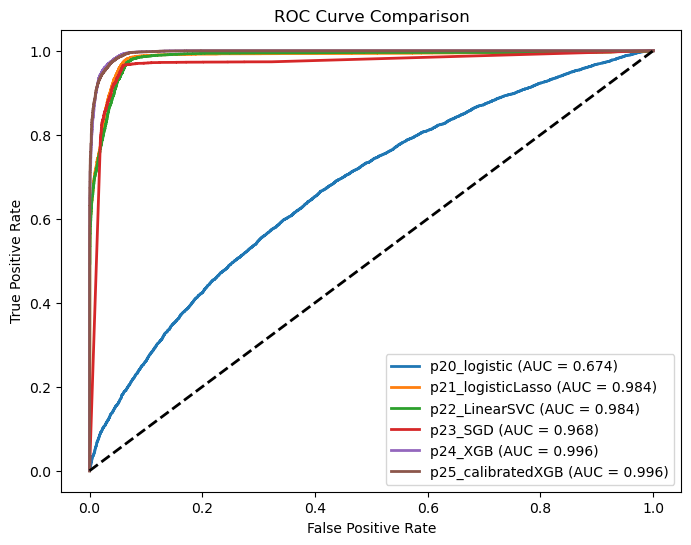

In [10]:

fits_pickles =['fits_pickle_p20_logistic.pkl'
             , 'fits_pickle_p21_logisticLasso.pkl'
             , 'fits_pickle_p22_LinearSVC.pkl'
             , 'fits_pickle_p23_SGD.pkl'
             , 'fits_pickle_p24_XGB.pkl' 
             , 'fits_pickle_p25_calibratedXGB.pkl']

colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # lime
    '#17becf',  # cyan
    '#393b79',  # dark blue
    '#637939'   # dark green
]

def plot_roc_curves(fits_pickles):
    plt.figure(figsize=(8, 6))
    
    for i, file in enumerate(fits_pickles):
        model_data = pd.read_pickle(file)
        plt.plot(model_data['fpr'], model_data['tpr'], color=colors[i % len(colors)], lw=2, 
                 label=f"{model_data['model_version']} (AUC = {model_data['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# plot_roc_curves(['lasso_metrics.pkl', 'ridge_metrics.pkl'])
plot_roc_curves(fits_pickles)